# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [1]:
"""
Looking at the logistic regression on the Titanic dataset,
I got a 78% accuracy, which isnt bad.
The model metrics of logistic regression seem to work a lot better
on binary(0,1)
While OLS can go beyond the binary, Logistic regression fits 
it a lot better, just because it focuses on binary data which my model
is using with Gender_class.
"""

'\nLooking at the logistic regression on the Titanic dataset,\nI got a 78% accuracy, which isnt bad.\nThe model metrics of logistic regression seem to work a lot better\non binary(0,1)\nWhile OLS can go beyond the binary, Logistic regression fits \nit a lot better, just because it focuses on binary data which my model\nis using with Gender_class.\n'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
dft = sns.load_dataset('titanic')

dft['gender_class'] = dft.sex.astype(str) + '_' + dft['class'].astype(str)

0.39317914367906703


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               survived   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.365
Method:                 Least Squares   F-statistic:                              103.5
Date:                Sat, 06 Feb 2021   Prob (F-statistic):                    4.88e-86
Time:                        15:08:20   Log-Likelihood:                         -632.74
No. Observations:                 891   AIC:                                      1275.
Df Residuals:                     886   BIC:                                      1299.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
female_Second     0.9211      0.057     16.267      0.000       0.810       1.032
female_Third      0.5000      0.041     12.155      0.000       0.419       0.581
male_First        0.3689      0.045      8.253      0.000       0.281       0.457
male_Second       0.1574      0.047      3.314      0.001       0.064       0.251
male_Third        0.1354      0.026      5.111      0.000       0.083       0.187
==============================================================================
Omnibus:                      123.472   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.623
Skew:                           0.693   Prob(JB):                     4.68e-21
Kurtosis:                       2.227   Cond. No.                         2.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

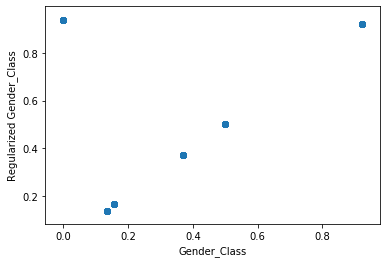

In [4]:
from sklearn.metrics import r2_score

titanic_x = pd.get_dummies(dft['gender_class'], drop_first=True)
titanic_y = dft['survived']

titanic_model1 = sm.OLS(titanic_y,titanic_x).fit(alpha = 0.5)
titanic_prediction1 = titanic_model1.predict(titanic_x)
clf = Ridge(alpha=1.0)
clf.fit(titanic_x, titanic_y)
y_prediction_regularized = clf.predict(titanic_x)
titanic_prediction_reg = titanic_model1.predict(titanic_x)
r2 = r2_score(titanic_y,y_prediction_regularized)
print(r2)


plt.scatter(titanic_prediction1, y_prediction_regularized)

plt.xlabel("Gender_Class")
plt.ylabel("Regularized Gender_Class")
titanic_model1.summary()

In [43]:
x = pd.get_dummies(dft['gender_class'], drop_first=True)
y = dft['survived']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

logistic_regression = LogisticRegression()

logistic_regression.fit(x_train,y_train)

y_pred = logistic_regression.predict(x_test)

predictions = logistic_regression.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.82      0.83      0.82       139
           1       0.71      0.70      0.71        84

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223



In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[115,  24],
       [ 25,  59]])

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()
clf_tree.fit(x_train, y_train)

y_score1 = clf_tree.predict_proba(x_test)[:,1]
y_score2 = logistic_regression.predict_proba(x_test)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1),'\n')
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score2),'\n')


roc_auc_score for DecisionTree:  0.8452809181226447 

roc_auc_score for Logistic Regression:  0.8433110654333675 



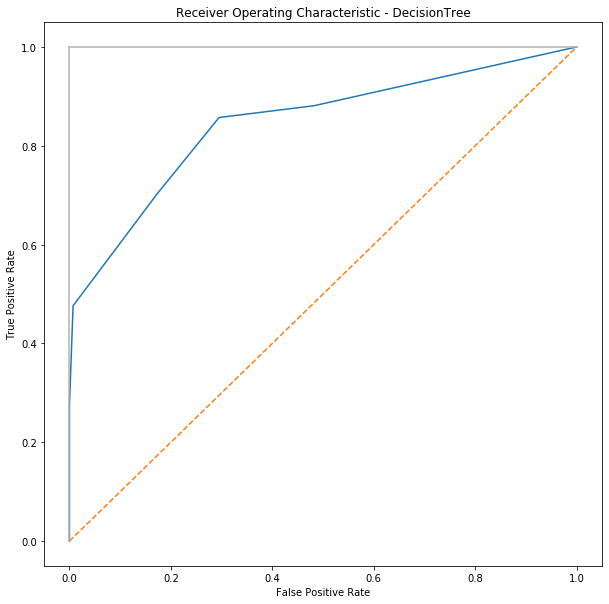

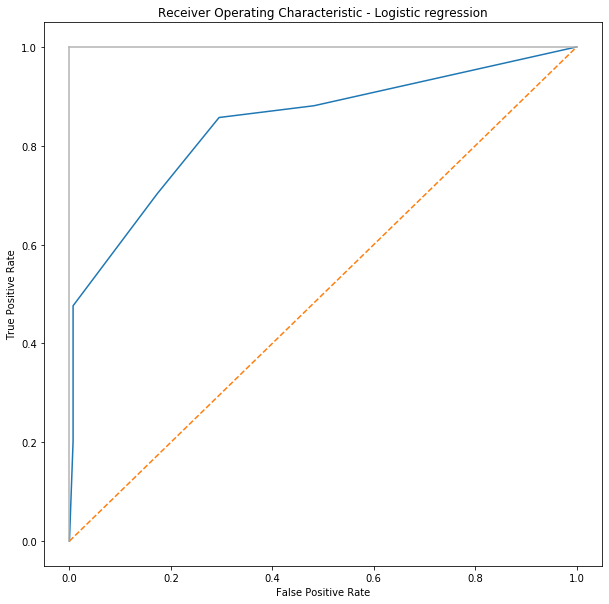

In [22]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [30]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [31]:
x1, y1 = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
std_scaler = StandardScaler()

(-0.5, 27.5, 27.5, -0.5)

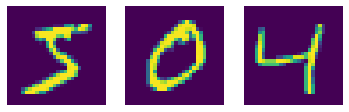

In [33]:
digit = x1[0]
d_pixels = digit.reshape(28,28)
plt.subplot(131)
plt.imshow(d_pixels)
plt.axis('off')
digit = x1[1]
d_pixels = digit.reshape(28,28)
plt.subplot(132)
plt.imshow(d_pixels)
plt.axis('off')
digit = x1[2]
d_pixels = digit.reshape(28,28)
plt.subplot(133)
plt.imshow(d_pixels)
plt.axis('off')

In [52]:
std_scaler.fit(x1)
scale_features = std_scaler.transform(x1)

x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.25,random_state=42)

In [53]:
d_model = LogisticRegression(multi_class='multinomial',solver='lbfgs')
d_model.fit(x1_train, y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
preds = d_model.predict(x1_train)
test_preds = d_model.predict(x1_test)

In [ ]:
"""
Accuracy ~92%
"""

In [55]:
from sklearn.metrics import accuracy_score

accuracy_score(y1_train, preds)
accuracy_score(y1_test, test_preds)

0.9210285714285714

(-0.5, 27.5, 27.5, -0.5)

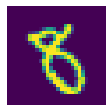

In [56]:
digit = x1_test[2]
d_pixels = digit.reshape(28,28)
plt.subplot(131)
plt.imshow(d_pixels)
plt.axis('off')

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [ ]:
"""

I guess the moral of this story is dont bring your kids fishing
if you want to catch something LOL

based on the first model below using Poission,
for every 1 kid you bring, results in a negative correlation.
You'll miss catching 1.7 almost 2 fish.

The other variables have a positive correlation, with live bait being the 
strongest. Which from experience fishing, makes all the difference.

Using a camper van has a small impact on the fish caught, but still
has a positive coef

The number of persons is also positive, the more people you bring fishing
the higher the odds of a catch. Does this really effect the probability of catching a fish?
I dont think so, at least not a much as using live bait.

Although based on the stage 2 approach, the persons variable has a higher coef.
its also more significant than some of the other variables, when looking at the p-value.

I think its a bit skewed, just because not everyone in the group may have fished.
and if they were using live bait, that would probably increase the persons variables correlation.

"""

In [72]:
fish = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/3-7-glm/data/fish.csv')

x = fish[['LIVE_BAIT','CAMPER','PERSONS','CHILDREN']]
y = fish['FISH_COUNT']

sm.Poisson(y, sm.add_constant(x)).fit().summary()

Optimization terminated successfully.
         Current function value: 3.167911
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      245
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                  0.5193
Time:                        13:00:32   Log-Likelihood:                -791.98
converged:                       True   LL-Null:                       -1647.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3901      0.265    -12.797      0.000      -3.909      -2.871
LIVE_BAIT      1.6697      0.233      7.160      0.000       1.213       2.127
CAMPER         0.8001      0.089      8.943      0.000       0.625       0.975
PERSONS        1.0740      0.039     27.534      0.000       0.998       1.150
CHILDREN      -1.7099      0.081    -21.005      0.000      -1.869      -1.550
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sat, 06 Feb 2021   Prob (F-statistic):           2.90e-11
Time:                        12:59:12   Log-Likelihood:                -938.12
No. Observations:                 250   AIC:                             1888.
Df Residuals:                     244   BIC:                             1909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4807      2.556     -4.100      0.000     -15.516      -5.445
LIVE_BAIT      6.3331      2.468      2.566      0.011       1.471      11.195
CAMPER         6.9381      2.233      3.108      0.002       2.541      11.336
PERSONS        9.5638      2.288      4.180      0.000       5.058      14.070
CHILDREN     -14.1342      3.950     -3.578      0.000     -21.915      -6.353
stage1       -23.8062     10.774     -2.210      0.028     -45.028      -2.584
==============================================================================
Omnibus:                      420.458   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114163.931
Skew:                           8.715   Prob(JB):                         0.00
Kurtosis:                     106.228   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

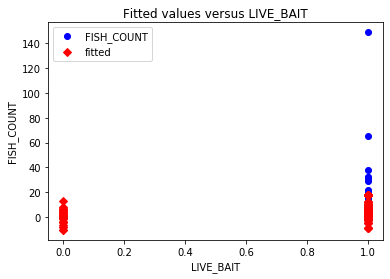

In [70]:
est1 = sm.Logit((y > 0).astype(int), sm.add_constant(x)).fit()

X = pd.DataFrame(sm.add_constant(x))

X['stage1'] = est1.predict(X)

X.columns = ['const', 'LIVE_BAIT','CAMPER','PERSONS','CHILDREN', 'stage1']

est2 = sm.OLS(y, X).fit()

sm.graphics.plot_fit(est2, 1, vlines=False)

est2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     15.35
Date:                Sat, 06 Feb 2021   Prob (F-statistic):           6.61e-15
Time:                        12:59:51   Log-Likelihood:                -927.57
No. Observations:                 250   AIC:                             1869.
Df Residuals:                     243   BIC:                             1894.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5088      3.417      0.149      0.882      -6.223       7.240
LIVE_BAIT      7.1208      2.377      2.995      0.003       2.438      11.803
CAMPER         7.0576      2.145      3.290      0.001       2.833      11.283
PERSONS        8.4021      2.212      3.798      0.000       4.045      12.759
CHILDREN     -15.3439      3.804     -4.034      0.000     -22.837      -7.851
stage1       -71.8939     14.672     -4.900      0.000    -100.794     -42.994
stage1_2      47.8456     10.346      4.624      0.000      27.466      68.226
==============================================================================
Omnibus:                      415.272   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113017.251
Skew:                           8.487   Prob(JB):                         0.00
Kurtosis:                     105.769   Cond. No.                         86.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

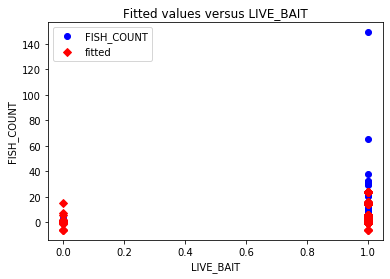

In [71]:
X['stage1_2'] = X.stage1 ** 2

est2 = sm.OLS(y, X).fit()
sm.graphics.plot_fit(est2, 1, vlines=False)
est2.summary()

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [81]:
!pip install lifelines

     |████████████████████████████████| 347 kB 676 kB/s 
     |████████████████████████████████| 55 kB 1.4 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=227b4eb4ace6d8d0e7876d297b2d8ba3a4d15380fdabd97ed62bb2121e42cf51
  Stored in directory: /Users/kalebmckenzie/Library/Caches/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47990 sha256=1ceba92a4e22d21b00b32de2062bd4ddf2b77e132342be315163681cd9189ebb
  Stored in directory: /Users/kalebmckenzie/Library/Caches/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd-gamma autograd


# 5.1

In [8]:
from lifelines import KaplanMeierFitter

df = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/3-7-glm/data/telco_churn.csv')

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [9]:
cat_cols = [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID') 

In [11]:
kmf = KaplanMeierFitter() 
T = df['tenure']     
E = df['Churn']         

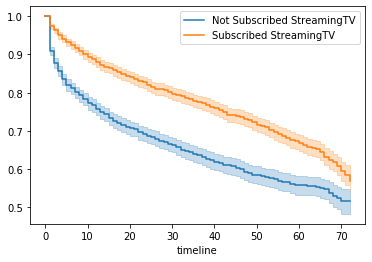

In [12]:
kmf1 = KaplanMeierFitter() 

groups = df['StreamingTV']
i1 = (groups == 'No')      
i2 = (groups == 'Yes')     

kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)


# 5.2

In [13]:
from lifelines import CoxPHFitter

df_r = df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]

In [19]:
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
7038,24,0,84.80,0,1,1,1,1,0,1
7039,72,0,103.20,0,0,1,1,1,0,1
7040,11,0,29.60,0,0,1,1,0,0,0
7041,4,1,74.40,1,1,1,0,1,0,0


In [42]:
cph = CoxPHFitter()   
model = cph.fit(df_dummy, duration_col='tenure', event_col='Churn')
model.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2021-02-06 20:42:56 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
MonthlyCharges                   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SeniorCitizen                     0.40       1.49       0.06             0.29             0.50                 1.33                 1.66
gender_Male                      -0.01       0.99       0.05            -0.10             0.08                 0.90                 1.08
Partner_Yes                      -0.81       0.45       0.05            -0.92            -0.70                 0.40                 0.50
Dependents_Yes                   -0.36       0.70       0.07            -0.49            -0.22                 0.61                 0.80
PhoneService_Yes                  0.69       2.00       0.10             0.49             0.90                 1.63                 2.45
StreamingTV_No internet service  -2.10       0.12       0.13            -2.36            -1.84                 0.09                 0.16
StreamingTV_Yes                  -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93

                                     z      p   -log2(p)
covariate                                               
MonthlyCharges                   -6.13 <0.005      30.06
SeniorCitizen                     7.16 <0.005      40.15
gender_Male                      -0.23   0.82       0.29
Partner_Yes                     -14.93 <0.005     164.98
Dependents_Yes                   -5.21 <0.005      22.37
PhoneService_Yes                  6.65 <0.005      34.96
StreamingTV_No internet service -15.79 <0.005     184.09
StreamingTV_Yes                  -3.10 <0.005       9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

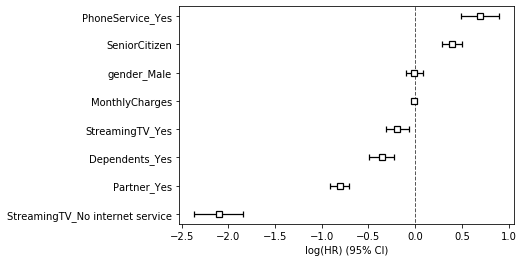

In [132]:
cph.plot()